In [1]:
import sys
sys.path.append("../")

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from rcgp.experimental import SpatioTemporalRCGP
from data.simulations import generate_gp_temporal_data

plt.rc('font', family='serif', size=12)

In [2]:
def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    outliers_loc = [50, 53, 57, 59, 65]

    noise = tc.distributions.Normal(loc=0, scale=20.).sample((len(outliers_loc), ))
    y_outliers[outliers_loc] = y_outliers[outliers_loc] + noise
    return y_outliers, outliers_loc

true_lengthscale, true_magnitude, true_var_y = (0.2, 2., 0.25)
Xs, Ys, true_func = generate_gp_temporal_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

value for beta that should be good - sqrt(True variance / 2) :  0.3535533905932738


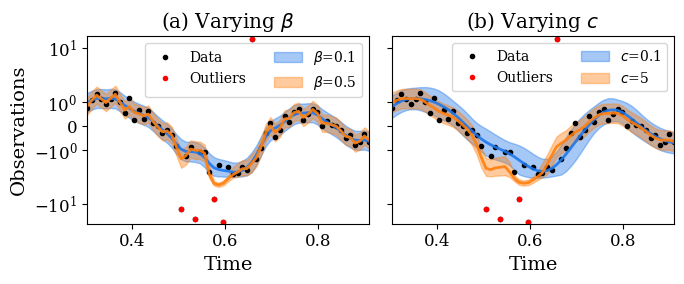

In [ ]:
strcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys_outliers.reshape(-1,1), p=1)

strcgp.activate_robustness(func="m_pred")
#We select hyperparams from other notebook where we optimize this data.
strcgp.var_y = 0.014
strcgp.temporal_lengthscale = 0.198
strcgp.temporal_magnitude = 3.01

fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)
for i in range(2):
    axs[i].plot(Xs, Ys_outliers, '.', color='black', label='Data')
    axs[i].plot(Xs[outliers_loc], Ys_outliers[outliers_loc], '.', color='red', label='Outliers')


for color, beta_val in zip(["#1f77e9", "#ff7f0e"], [0.1, 0.5]):
    with tc.no_grad(): 
        strcgp.beta = beta_val
        (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
        pred_strcgp = pred_strcgp.squeeze().numpy()
        std_strcgp = tc.sqrt(strcgp.var_y.clone().detach() + std_strcgp**2).numpy()

    axs[0].plot(Xs, pred_strcgp, alpha=0.9, linewidth=2, color=color)
    axs[0].fill_between(Xs, pred_strcgp - 3 * std_strcgp, pred_strcgp + 3 * std_strcgp, alpha=0.4, color=color, label=r"$\beta$={}".format(beta_val))

strcgp.beta = None
for color, c_val in zip(["#1f77e9", "#ff7f0e"],[0.1, 5]):
    with tc.no_grad(): 
        strcgp.c = c_val
        (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
        pred_strcgp = pred_strcgp.squeeze().numpy()
        std_strcgp = tc.sqrt(strcgp.var_y.clone().detach() + std_strcgp**2).numpy()

    axs[1].plot(Xs, pred_strcgp, alpha=0.9, linewidth=2, color=color)
    axs[1].fill_between(Xs, pred_strcgp - 3 * std_strcgp, pred_strcgp + 3 * std_strcgp, alpha=0.4, color=color, label=r"$c$={}".format(c_val))


print("value for beta that should be good - sqrt(True variance / 2) : ", np.sqrt(true_var_y / 2))

for i in range(2) : axs[i].set_xlim(Xs[30], Xs[-10])

axs[0].set_yscale("symlog")
axs[0].legend(ncol=2, fontsize=10)
axs[1].legend(ncol=2, fontsize=10)
axs[0].set_title(r"(a) Varying $\beta$")
axs[1].set_title(r"(b) Varying $c$")
for i in range(2) : axs[i].set_xlabel("Time", fontsize=14)
axs[0].set_ylabel(r"Observations", fontsize=14)
fig.tight_layout()

#fig.savefig("./results/varying-beta-c-temporal.pdf", format='pdf', bbox_inches='tight')